# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)
training set after dropping score na:  (1485341, 9)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          

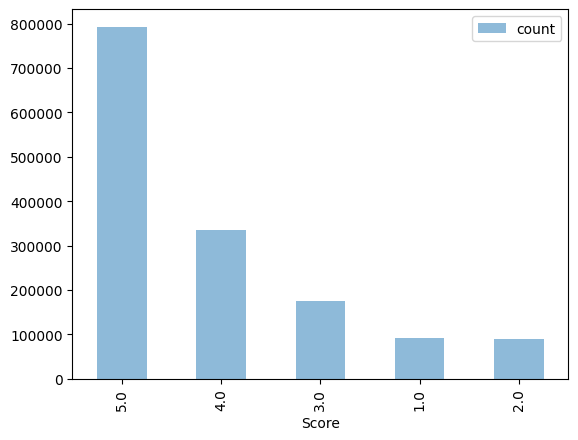


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

# Separate rows with missing scores
test_set = trainingSet[trainingSet['Score'].isnull()]   #rows missing score for testing 
trainingSet = trainingSet.dropna(subset=['Score']) 

print("training set after dropping score na: ", trainingSet.shape)
print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Save the datasets as pickle files
with open('./data/train_with_score.pkl', 'wb') as f:
    pickle.dump(trainingSet, f)
    
with open('./data/missing_score_rows.pkl', 'wb') as f:
    pickle.dump(test_set, f)
    
with open('./data/testingSet.pkl', 'wb') as f:
    pickle.dump(testingSet, f)


Clean Data

In [3]:
import numpy as np 
import re 

def clean_data(df):
    #drop NaN values from score column
    # df = df.dropna(subset=['Score']) 
    #drop irrelevant columns
    # df = df.drop(columns=['UserId'])
    # Handle missing 'ProductId'
    df['ProductId'].fillna('UnknownProduct', inplace=True)
    # Handle missing 'UserId'
    df['UserId'].fillna('UnknownUser', inplace=True)

    #handle helpfulness denominator of 0 
    df['Helpfulness'] = np.where(df['HelpfulnessDenominator'] == 0, 0, 
                                        df['HelpfulnessNumerator'] / df['HelpfulnessDenominator'])
    df['Helpfulness'] = df['Helpfulness'].fillna(0) #replace 0 with na 

    #convert unix to datetime
    df['Time'] = pd.to_datetime(df['Time'], unit='s')

    # Handle missing 'Score'
    if 'Score' in df.columns:
        # For training data, drop rows with missing 'Score'
        df = df.dropna(subset=['Score'])
        df['Score'] = df['Score'].astype(int)
    else:
        # For test data, 'Score' may not be present or is what we're predicting
        pass

    # Handle missing 'Time'
    df['Time'].fillna(df['Time'].median(), inplace=True)  # Fill with median timestamp
    df['Time'] = pd.to_datetime(df['Time'], unit='s', errors='coerce')
    # Handle any conversion errors
    df['Time'].fillna(pd.Timestamp('2000-01-01'), inplace=True)

    # Extract time features
    df['Year'] = df['Time'].dt.year
    df['Month'] = df['Time'].dt.month
    df['DayOfWeek'] = df['Time'].dt.dayofweek
    df.drop(columns=['Time'], inplace=True)

    # Fill missing values in 'Summary' and 'Text' columns
    df['Summary'].fillna('No summary', inplace=True)
    df['Text'].fillna('No text', inplace=True)

    # Apply text cleaning
    df['CleanedText'] = df['Text'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')
    df['CleanedSummary'] = df['Summary'].apply(lambda x: clean_text(x) if isinstance(x, str) else '')

     # Handle missing 'Id'
    if 'Id' not in df.columns or df['Id'].isnull().any():
        # Generate unique Ids if missing
        df['Id'] = df.index

    # Check for null values
    print("Missing values after processing:")
    print(df.isnull().sum())

    return df 

def clean_text(text):
    # Remove punctuation, convert to lowercase
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text

cleaned_train = clean_data(trainingSet)

# Extract submission data from trainingSet based on IDs in testingSet
X_submission = trainingSet[trainingSet['Id'].isin(testingSet['Id']) & trainingSet['Score'].isnull()].copy()
X_submission = clean_data(X_submission)

# Save the cleaned DataFrame as a pickle file
with open('./data/cleaned_train.pkl', 'wb') as f:
    pickle.dump(cleaned_train, f)

/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_818/2509884505.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ProductId'].fillna('UnknownProduct', inplace=True)
/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_818/2509884505.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

Missing values after processing:
Id                        0
ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Summary                   0
Text                      0
Score                     0
Helpfulness               0
Year                      0
Month                     0
DayOfWeek                 0
CleanedText               0
CleanedSummary            0
dtype: int64
Missing values after processing:
Id                        0
ProductId                 0
UserId                    0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Summary                   0
Text                      0
Score                     0
Helpfulness               0
Year                      0
Month                     0
DayOfWeek                 0
CleanedText               0
CleanedSummary            0
dtype: int64


/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_818/2509884505.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ProductId'].fillna('UnknownProduct', inplace=True)
/var/folders/mw/d6jh5r755yj5xb4v20prr1g00000gn/T/ipykernel_818/2509884505.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

In [4]:
# Sample 10% of the data
subset, _ = train_test_split(
    cleaned_train,
    train_size=0.10,
    stratify=cleaned_train['Score'],
    random_state=42
)

print("Full dataset class distribution:")
print(cleaned_train['Score'].value_counts(normalize=True))
print("\nSubset class distribution:")
print(subset['Score'].value_counts(normalize=True))

Full dataset class distribution:
Score
5    0.533994
4    0.225691
3    0.118547
1    0.061393
2    0.060375
Name: proportion, dtype: float64

Subset class distribution:
Score
5    0.533992
4    0.225692
3    0.118545
1    0.061393
2    0.060377
Name: proportion, dtype: float64


# Adding Features

In [5]:
from textblob import TextBlob
import os
import numpy as np
import textstat
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Define your cleaning and feature engineering functions

def clean_data(df):
    # Add your data cleaning steps here
    # Ensure to return the cleaned DataFrame
    return df

def add_features_to(df, tfidf_vectorizer=None):
    # Convert 'Text' and 'Summary' to string type
    df['Text'] = df['Text'].astype(str)
    df['Summary'] = df['Summary'].astype(str)

    # Basic text features
    df['TextLength'] = df['Text'].apply(lambda x: len(x.split()))
    df['SummaryLength'] = df['Summary'].apply(lambda x: len(x.split()))

    # Exclamation and Question Marks
    df['ExclamationMarks'] = df['Text'].apply(lambda x: x.count('!'))
    df['QuestionMarks'] = df['Text'].apply(lambda x: x.count('?'))

    # Positive and Negative Word Counts
    positive_words = {'good', 'great', 'excellent', 'amazing', 'love', 'fantastic', 'awesome'}
    negative_words = {'bad', 'terrible', 'awful', 'poor', 'worst', 'hate', 'boring'}
    df['PositiveWords'] = df['Text'].apply(lambda x: sum(word.lower() in positive_words for word in x.split()))
    df['NegativeWords'] = df['Text'].apply(lambda x: sum(word.lower() in negative_words for word in x.split()))

    # Sentiment Score
    df['SentimentScore'] = df['PositiveWords'] - df['NegativeWords']
    df['HasUppercaseWord'] = df['Text'].apply(lambda x: int(any(word.isupper() for word in x.split())))

    # Advanced Sentiment
    df['SentimentPolarity'] = df['Text'].apply(get_sentiment)

    # Vocabulary richness and review length
    df['VocabularyRichness'] = df['Text'].apply(vocabulary_richness)
    df['ReviewLength'] = df['Text'].apply(lambda x: len(x.split()))

    # Additional Textual Features
    df['AvgWordLength'] = df['Text'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['UniqueWordCount'] = df['Text'].apply(lambda x: len(set(x.split())))
    df['CapitalizedWordCount'] = df['Text'].apply(lambda x: sum(word.isupper() for word in x.split()))

    # Readability Score (Flesch Reading Ease)
    df['FleschReadingEase'] = df['Text'].apply(lambda x: textstat.flesch_reading_ease(x))

    # Extract TF-IDF Features
    if tfidf_vectorizer is None:
        tfidf_vectorizer = TfidfVectorizer(max_features=500)
        tfidf_matrix = tfidf_vectorizer.fit_transform(df['Text'])
    else:
        tfidf_matrix = tfidf_vectorizer.transform(df['Text'])

    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out(), index=df.index)
    df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

    return df, tfidf_vectorizer

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

def vocabulary_richness(text):
    words = text.split()
    unique_words = set(words)
    return len(unique_words) / len(words) if words else 0

# Check if preprocessed data exists
if os.path.exists('./data/X_train.pkl') and os.path.exists('./data/X_submission.pkl') and os.path.exists('./data/tfidf_vectorizer.pkl'):
    # Load preprocessed data
    with open('./data/X_train.pkl', 'rb') as f:
        X_train_full = pickle.load(f)
    with open('./data/X_submission.pkl', 'rb') as f:
        X_submission = pickle.load(f)
    with open('./data/tfidf_vectorizer.pkl', 'rb') as f:
        tfidf_vectorizer = pickle.load(f)
else:
    # Apply feature engineering to the cleaned training data
    X_train_full, tfidf_vectorizer = add_features_to(subset)

    # Apply feature engineering to the cleaned submission data using the same TF-IDF vectorizer
    X_submission, _ = add_features_to(X_submission, tfidf_vectorizer=tfidf_vectorizer)

    # Save the processed data
    with open('./data/X_train.pkl', 'wb') as f:
        pickle.dump(X_train_full, f)
    with open('./data/X_submission.pkl', 'wb') as f:
        pickle.dump(X_submission, f)
    with open('./data/tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)




# Sample + Split into training and testing set

In [6]:

# Separate features and target variable
Y = X_train_full['Score'].astype(int)
X = X_train_full.drop(columns=['Score'])

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.25,
    random_state=0,
    stratify=Y
)
print(X_train.head())

            Id   ProductId          UserId  HelpfulnessNumerator  \
148043  876768  B00074OLQS  A1RKUR9NY4Z353                     0   
94343   978282  B000ERVJOA   A37RIRXE3WECZ                    57   
3089    826840  B00028G6RQ  A3W3BY7AJB4OKR                     7   
27781   505994  B00000JDIQ  A2KGMLHTZAYTRT                     0   
52896   947569  B000BPL2EW  A23HTHSRWOI7Y0                    10   

        HelpfulnessDenominator                                      Summary  \
148043                       0           grandchildren just love this show.   
94343                       58            A Great Addition to Your Rotation   
3089                        16                                SHUT UP B*TCH   
27781                        1                             plenty of action   
52896                       14  Listen carefully,I shall say this only once   

                                                     Text  Helpfulness  Year  \
148043  Its hard for a toddler to sp

# Feature Selection

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# Define feature columns
features = [
    'TextLength',
    'SummaryLength',
    'ExclamationMarks',
    'QuestionMarks',
    'PositiveWords',
    'NegativeWords',
    'SentimentScore',
    'HasUppercaseWord',
    'SentimentPolarity',
    'VocabularyRichness',
    'ReviewLength',
    'AvgWordLength',
    'UniqueWordCount',
    'CapitalizedWordCount',
    'FleschReadingEase'
    # The TF-IDF features will be added dynamically and are not listed here
]

# Get TF-IDF feature names
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
# Extend the features list
features.extend(tfidf_feature_names)

# Select features from original dataset and fill any missing values
X_train_select = X_train[features].fillna(0)
X_test_select = X_test[features].fillna(0)
X_submission_select = X_submission[features].fillna(0)

# Convert 'HasUppercaseWord' to integer
for df in [X_train_select, X_test_select, X_submission_select]:
    df['HasUppercaseWord'] = df['HasUppercaseWord'].astype(int)

# Scale the subsample data
scaler = StandardScaler()
# Fit the scaler on the training data and transform
X_train_scaled = scaler.fit_transform(X_train_select)

# Transform the test and submission data
X_test_scaled = scaler.transform(X_test_select)
X_submission_scaled = scaler.transform(X_submission_select)


# Model Creation

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize KNN with k=5
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(X_train_scaled, Y_train)


k_range = list(range(1, 31))
param_grid = {'n_neighbors': k_range}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_test_scaled, Y_test)

# Best K value
best_k = grid.best_params_['n_neighbors']
print("Best K value:", best_k)

# Retrain KNN with best K
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_test_scaled, Y_test)

Y_test_predictions = knn.predict(X_test_scaled)
print("Classification Report:")
print(classification_report(Y_test, Y_test_predictions))
print("Accuracy on testing set =", accuracy_score(Y_test, Y_test_predictions))


KeyboardInterrupt: 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'class_weight': 'balanced'}
Classification Report:
              precision    recall  f1-score   support

           1       0.46      0.32      0.38      2280
           2       0.32      0.03      0.05      2242
           3       0.33      0.06      0.10      4402
           4       0.36      0.12      0.18      8381
           5       0.59      0.95      0.73     19829

    accuracy                           0.56     37134
   macro avg       0.41      0.29      0.29     37134
weighted avg       0.49      0.56      0.47     37134

Accuracy on testing set = 0.563580546130231


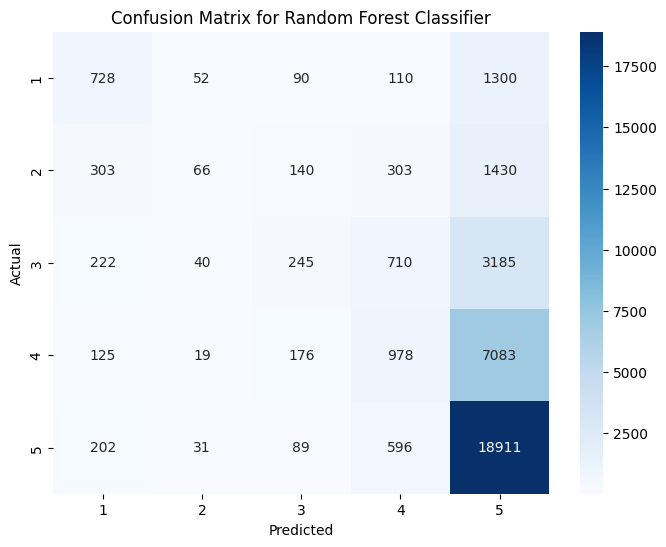

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# Sample 10% of the training data for tuning
X_tune, _, Y_tune, _ = train_test_split(
    X_train_scaled,
    Y_train,
    train_size=0.1,
    stratify=Y_train,
    random_state=42
)

# Fit the grid search to the smaller dataset
# grid_search.fit(X_tune, Y_tune)

param_distributions = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [2],
    'min_samples_leaf': [2],
    'class_weight': ['balanced']
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=10,  # Number of parameter settings that are sampled
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

model = random_search.fit(X_tune, Y_tune)

print("Best parameters found:", random_search.best_params_)
rf_best = random_search.best_estimator_

# Evaluate the best model
Y_test_pred = rf_best.predict(X_test_scaled)


print("Classification Report:")
print(classification_report(Y_test, Y_test_pred))
print("Accuracy on testing set =", accuracy_score(Y_test, Y_test_pred))

# Confusion Matrix
cm = confusion_matrix(Y_test, Y_test_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=sorted(Y_train.unique()), yticklabels=sorted(Y_train.unique()))
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Model Evaluation

Accuracy on testing set =  0.563580546130231


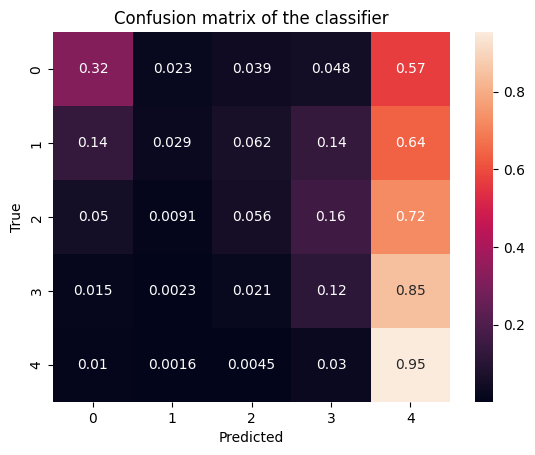

In [14]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_pred))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [19]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)
print(X_submission.shape)
print(X_submission_select.shape)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


(212192, 524)
(212192, 515)
